In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [5]:
# Load the dataset
battery_soh = pd.read_csv('/Users/thyag/Desktop/projects/eloctrocute/sample_data/simulated_battery_soh.csv', index_col=0, parse_dates=True)
battery_soh

,Battery_SOH
2023-01-01,99.621735
2023-01-02,100.225259
2023-01-03,100.536247
2023-01-04,100.158840
2023-01-05,99.342589
...,...
2023-09-03,81.909173
2023-09-04,81.337226
2023-09-05,81.491998
2023-09-06,81.186915


In [6]:
# Stationarity Test Function
def test_stationarity(timeseries, series_name="Time Series"):
    """Performs ADF test and prints results."""
    print(f'--- Results of Dickey-Fuller Test for {series_name} ---')
    # The adfuller function returns several values, we are primarily interested in the p-value
    # H0 (Null Hypothesis): The series has a unit root (it is non-stationary).
    # H1 (Alternative Hypothesis): The series does not have a unit root (it is stationary).
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print(f"Conclusion: p-value ({result[1]:.3f}) <= 0.05. Reject the Null Hypothesis (H0).")
        print(f"'{series_name}' is likely STATIONARY.")
        return True
    else:
        print(f"Conclusion: p-value ({result[1]:.3f}) > 0.05. Fail to Reject the Null Hypothesis (H0).")
        print(f"'{series_name}' is likely NON-STATIONARY.")
        return False

In [7]:
# Test Stationarity of Original Data
print("Testing stationarity of the original data...")
is_stationary_original = test_stationarity(battery_soh, "Original Battery SOH")

Testing stationarity of the original data...
--- Results of Dickey-Fuller Test for Original Battery SOH ---
ADF Statistic: 5.470
p-value: 1.000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Conclusion: p-value (1.000) > 0.05. Fail to Reject the Null Hypothesis (H0).
'Original Battery SOH' is likely NON-STATIONARY.


In [11]:
# Apply Differencing. d=1 means we subtract the previous value from the current value.
battery_soh_diff1 = battery_soh.diff().dropna() # dropna removes the first NaN value created by diff()
battery_soh_diff1

,Battery_SOH
2023-01-02,0.603524
2023-01-03,0.310988
2023-01-04,-0.377407
2023-01-05,-0.816251
2023-01-06,0.259641
...,...
2023-09-03,-0.394164
2023-09-04,-0.571947
2023-09-05,0.154772
2023-09-06,-0.305084


In [9]:
# Test Stationarity of Differenced Data
is_stationary_diff1 = test_stationarity(battery_soh_diff1, "1st Order Differenced SOH")

--- Results of Dickey-Fuller Test for 1st Order Differenced SOH ---
ADF Statistic: -7.654
p-value: 0.000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Conclusion: p-value (0.000) <= 0.05. Reject the Null Hypothesis (H0).
'1st Order Differenced SOH' is likely STATIONARY.


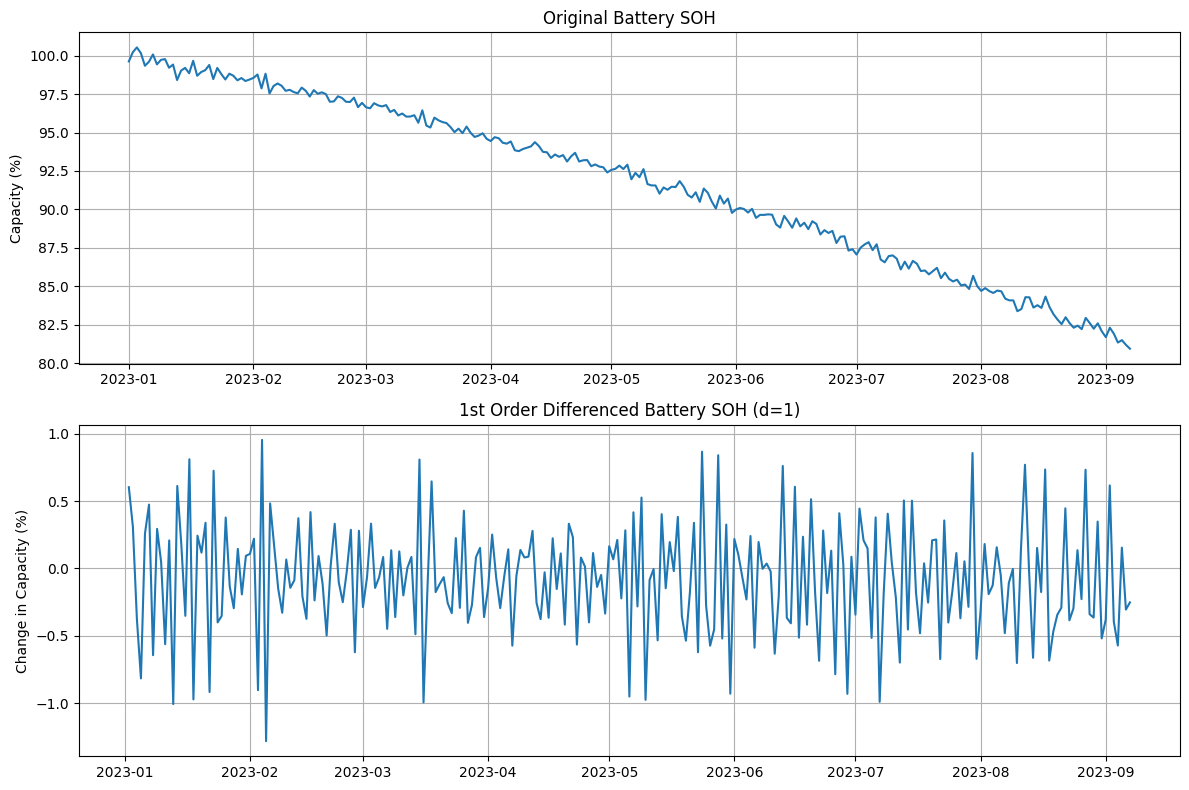

In [10]:
# Visualize Original vs Differenced Data
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(battery_soh)
plt.title('Original Battery SOH')
plt.ylabel('Capacity (%)')
plt.grid(True)

plt.subplot(212)
plt.plot(battery_soh_diff1)
plt.title('1st Order Differenced Battery SOH (d=1)')
plt.ylabel('Change in Capacity (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# Determine final d
determined_d = 0
if not is_stationary_original:
    if is_stationary_diff1:
        determined_d = 1
        print(f"\nFirst differencing achieved stationarity. We will use d = {determined_d}.")
    else:
        # Optional: Try second differencing if first wasn't enough
        print("\nFirst differencing might not be enough. Let's try second differencing (d=2)...")
        battery_soh_diff2 = battery_soh_diff1.diff().dropna()
        is_stationary_diff2 = test_stationarity(battery_soh_diff2, "2nd Order Differenced SOH")
        if is_stationary_diff2:
             determined_d = 2
             print(f"\nSecond differencing achieved stationarity. We will use d = {determined_d}.")
        else:
             determined_d = 1 # Default back to 1 if 2 also fails, or investigate further
             print("\nSecond differencing also failed or wasn't tested thoroughly. Defaulting to d=1, but review needed.")
else:
    print("\nOriginal series is stationary. We will use d = 0.")
    # If original is stationary, we use the original series for ACF/PACF plots later
    stationary_series_for_plots = battery_soh
    determined_d = 0


First differencing achieved stationarity. We will use d = 1.


In [13]:
# Save the stationary series for further analysis
if determined_d == 1:
    stationary_series_for_plots = battery_soh_diff1
elif determined_d == 2:
     # Need to calculate diff2 if we determined d=2
     battery_soh_diff2 = battery_soh.diff().diff().dropna()
     stationary_series_for_plots = battery_soh_diff2
else: # d=0
    stationary_series_for_plots = battery_soh

stationary_series_for_plots.to_csv('/Users/thyag/Desktop/projects/eloctrocute/sample_data/stationary_battery_soh.csv')